# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$?

In [1]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet
from utils import calc_loss, mk_rand_matrix, mk_rand_matrix_envals

rng = np.random.default_rng()

In [2]:
# Define some arbitrary parameters
def create_process_3d(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.94])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process_3d(rng)

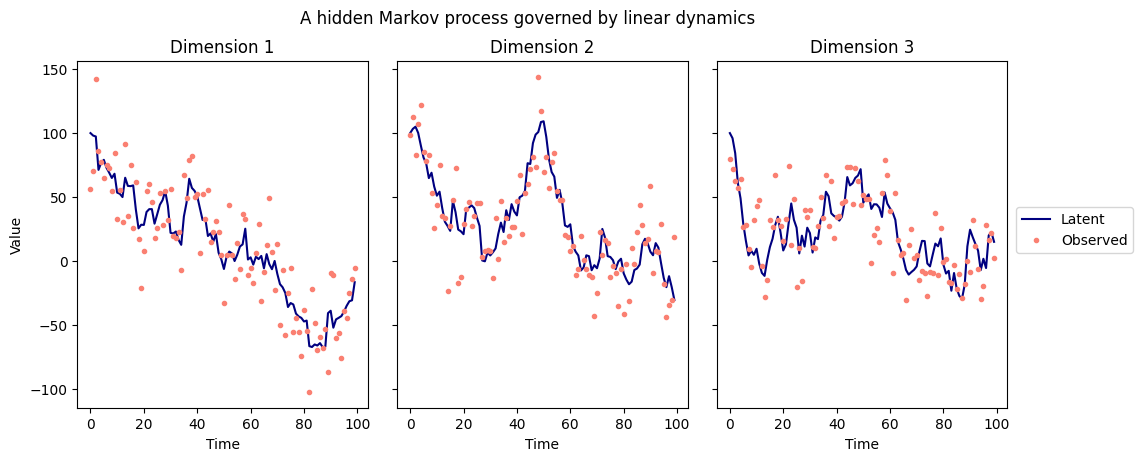

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

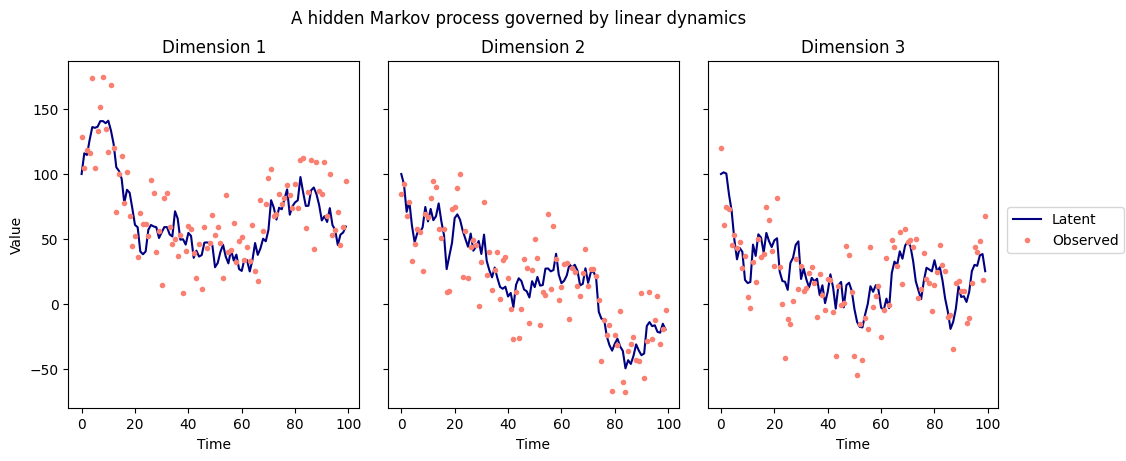

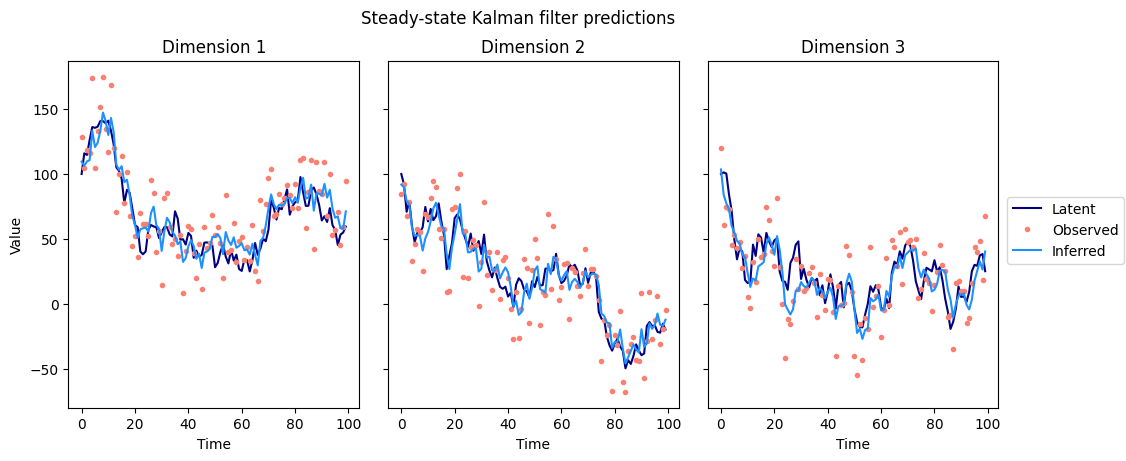

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

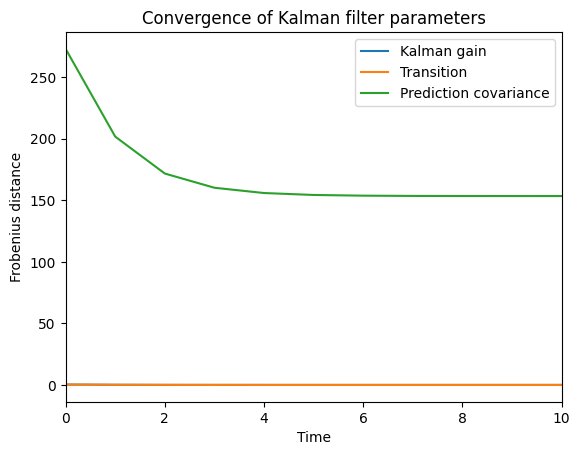

In [5]:
# Let's check how well the Kalman filter converges to the steady-state Kalman filter.
Sigma_infty_dist, K_infty_dist, M_infty_dist = kf.check_convergence()
plt.plot(np.arange(proc.num_steps), K_infty_dist, label='Kalman gain')
plt.plot(np.arange(proc.num_steps), M_infty_dist, label='Transition')
plt.plot(np.arange(proc.num_steps), Sigma_infty_dist, label='Prediction covariance')
plt.title('Convergence of Kalman filter parameters')
plt.xlabel('Time')
plt.ylabel('Frobenius distance')
plt.xlim(0,10)
plt.legend()
plt.show()


In [6]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng, np.array([0.98, 0.96, 0.94]))
proc = create_process_3d(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [7]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(3):
        M = mk_rand_matrix(rng, 3)
        for i in tqdm.tqdm(range(10)):
            c = i/10
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(np.linalg.norm(M2 - kf.M_infty, ord='fro'))
            losses.append(np.mean(Ls))
    return np.array(distances), np.array(losses)

#distances, losses = test_M_landscape()

In [8]:
# Let's try plotting our results
#plt.scatter(distances[:10], losses[:10])
#plt.scatter(distances[10:20], losses[10:20])
#plt.scatter(distances[20:], losses[20:])
#plt.xlabel('Frobenius distance between M and the optimal value')
#plt.ylabel('Average loss (100 simulated trials)')
#plt.title('Loss vs distance from Kalman filter theory')
#plt.show()

In [9]:
# What happens when we train the neural net on this task?
def compare_nn_kalman():
    nn = NeuralNet(0.1*mk_rand_matrix(rng, 3), 0.1*mk_rand_matrix(rng, 3), np.eye(3), proc.x0)
    ts, xs, ys = proc.simulate()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    losses = nn.train(np.array([1e-6]*10), 40, proc)
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Batch')
    plt.ylabel('Mean loss')
    plt.show()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    # How does it compare to a Kalman filter?
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)

#compare_nn_kalman()

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity. Can we plot a loss landscape for the task?

In [10]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
a_vals = np.array([-0.95, -0.8, 0, 0.8, 0.95])
num_a_ticks = a_vals.shape[0]
mk_range = 0.99
num_trials_per = 40
W = np.array([[1]])
start_from = 5

In [11]:
def find_nn_values_A_M_K_1d(num_nns=2):
    mks = [] # mks[i][j] contains the values of M and K for the jth trial with the ith value of A

    for i, a_ in enumerate(a_vals):
        A = np.array([[a_]])
        mks_i = []
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, 1), 0.1*mk_rand_matrix(rng, 1), np.eye(1), proc.x0)
            _, _, Ms, Ks = nn.train_until_converge(5e-7, 200, num_trials_per, proc, start_from,
                                                   print_loss=False, progress_bar=False)
            mks_i.append((Ms.flatten(), Ks.flatten()))
        mks.append(mks_i)

    return mks

mks = find_nn_values_A_M_K_1d()

100%|█████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.60s/it]


In [12]:
def test_A_M_K_loss_landscape_1d():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    
    for i1, a_ in tqdm.tqdm(enumerate(a_vals), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc, start_from)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

losses = test_A_M_K_loss_landscape_1d()

100%|█████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.95s/it]


(array([-0.06570867, -0.06545292, -0.06819836, -0.07337795, -0.08036238,
       -0.0885995 , -0.09854992, -0.11083469, -0.12258632, -0.13938508,
       -0.15491168, -0.16899342, -0.18332099, -0.19751318, -0.21272217,
       -0.22824276, -0.242033  , -0.25509085, -0.26635057, -0.27617542,
       -0.28577882, -0.29474833, -0.30317294]), array([-0.00410048,  0.05377344,  0.10069797,  0.14699393,  0.18974337,
        0.22766385,  0.26525219,  0.30444119,  0.33584161,  0.37648264,
        0.40883298,  0.43493394,  0.4584466 ,  0.48035388,  0.5019748 ,
        0.52275604,  0.53943464,  0.55398316,  0.56515743,  0.5737954 ,
        0.58214489,  0.58961338,  0.59585769]))


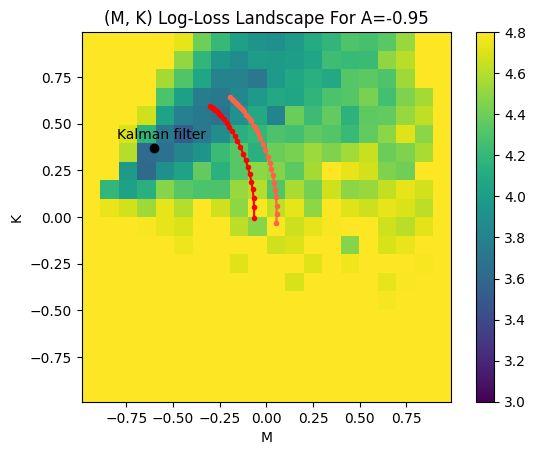

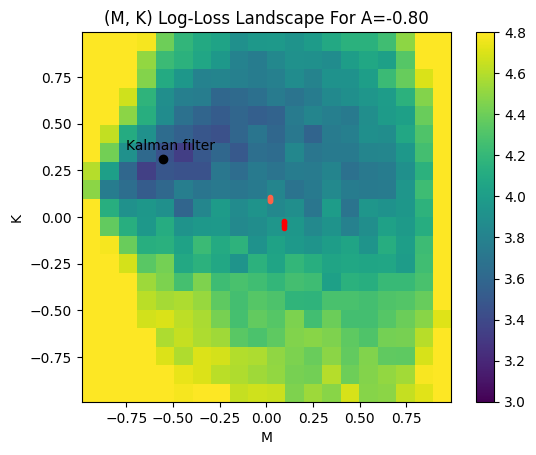

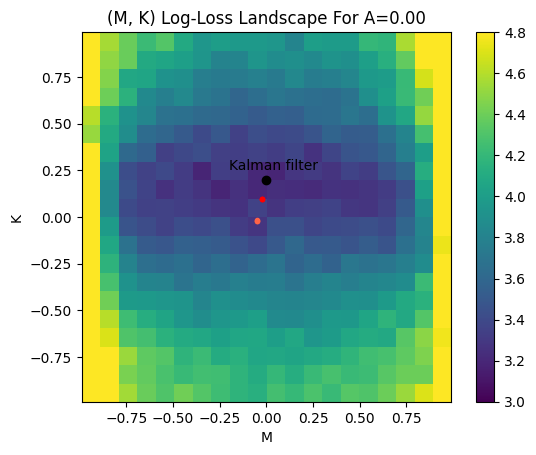

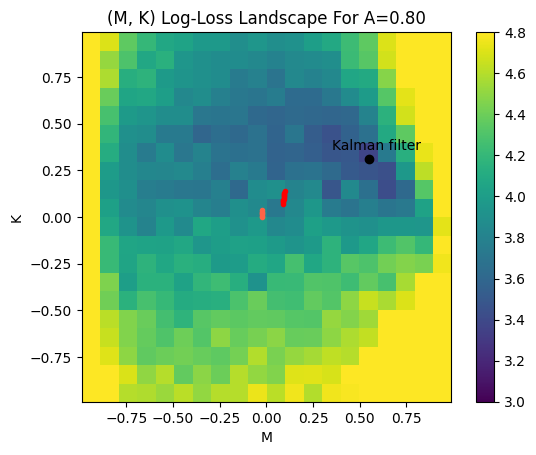

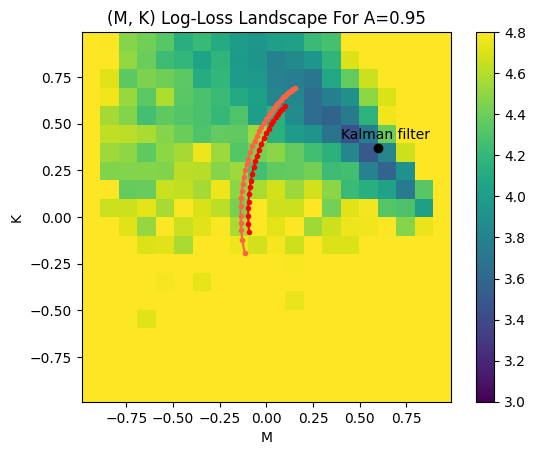

In [13]:
print(mks[0][0])
norm = matplotlib.colors.Normalize(3, 4.8)
for i1, a_ in enumerate(a_vals):

    # Loss landscape
    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
    plt.xlabel('M')
    plt.ylabel('K')

    # Where does the Kalman filter fall?
    A = np.array([[a_]])
    proc = create_1d_process(rng, A)
    kf = SteadyStateKalmanFilter(proc)
    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

    # What about the RNNs?
    colors = ['red', 'tomato']
    for j in range(2):
        plt.plot(mks[i1][j][0], mks[i1][j][1], color=colors[j], linestyle='-', marker='o', markersize=3)
    
    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
    plt.xlim(-1*mk_range, mk_range)
    plt.ylim(-1*mk_range, mk_range)
    plt.colorbar(c)
    plt.show()

In [ ]:
#def test_mk(proc, m_, k_):
#    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
#    nn = NeuralNet(M, K, W, proc.x0)
#    proc = create_1d_process(rng, A)
#    losses = nn.batch_test(100, proc)
#    print(np.mean(losses))

A = np.array([[a_vals[-1]]])
proc = create_1d_process(rng, A)
kf = SteadyStateKalmanFilter(proc)

m_ = mks[-1][0][0][-1]
k_ = mks[-1][0][1][-1]
#test_mk(proc, m_, k_)
#test_mk(proc, kf.M_infty, kf.K_infty)

ts, xs, ys = proc.simulate()

nn = NeuralNet(np.array([[m_]]), np.array([[k_]]), np.eye(1), proc.x0)
_, xhats = nn.forward(ys)
plot_hm_process('After training', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs, start_from))
print('M =', nn.M)
print('K =', nn.K)

xhats = kf.infer(ys)
plot_hm_process('Kalman filter', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs, start_from))
print('M =', kf.M_infty)
print('K =', kf.K_infty)

In [108]:
# What about two dimensions?
def create_2d_process(rng, A):
    x0 = np.array([100, 100])
    sigma_process = 5
    Sigma_process = (sigma_process**2)*np.eye(2)
    O = np.eye(2)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(2)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
A = mk_rand_matrix_envals(rng, np.array([0.9, 0.97]))
proc = create_2d_process(rng, A)
kf = SteadyStateKalmanFilter(proc)
mk_range = 0.99
num_trials_per = 40
W = np.eye(2)
start_from = 5

In [59]:
def test_K_loss_landscape_2d():
    M = kf.M_infty
    
    losses = np.zeros((num_ticks,num_ticks))    
    for i_k1, k_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
        for i_k2, k_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            K = mk_rand_matrix_envals(rng, np.array([k_ev1, k_ev2]))
            nn = NeuralNet(M, K, W, proc.x0)
            Ls = nn.batch_test(batch_size, proc, start_from)
            losses[i_k1,i_k2] = np.mean(Ls)
    
    return losses

losses_K = test_K_loss_landscape_2d()

100%|███████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.13s/it]


In [61]:
def test_M_loss_landscape_2d():
    K = kf.K_infty
    
    losses = np.zeros((num_ticks,num_ticks))    
    for i_m1, m_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
        for i_m2, m_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            M = mk_rand_matrix_envals(rng, 2, np.array([m_ev1, m_ev2]))
            nn = NeuralNet(M, K, W, proc.x0)
            Ls = nn.batch_test(batch_size, proc, start_from)
            losses[i_m1,i_m2] = np.mean(Ls)
    
    return losses

losses_M = test_M_loss_landscape_2d()

100%|███████████████████████████████████████████████████████| 20/20 [00:57<00:00,  2.87s/it]


In [97]:
def test_M_loss_landscape_2d_diagentry():
    K = kf.K_infty
    M = kf.K_infty
    
    losses = np.zeros((num_ticks,num_ticks))    
    for i_m1, m1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
        for i_m2, m2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            M[0,0] = m1
            M[1,1] = m2
            nn = NeuralNet(M, K, W, proc.x0)
            Ls = nn.batch_test(batch_size, proc, start_from)
            losses[i_m1,i_m2] = np.mean(Ls)
    
    return losses

losses_M_diag = test_M_loss_landscape_2d_diagentry()

100%|███████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


[[0.92493079 0.00743243]
 [0.1511769  0.94506921]]
[[0.80407715 0.06752418]
 [0.26222534 1.26568251]]


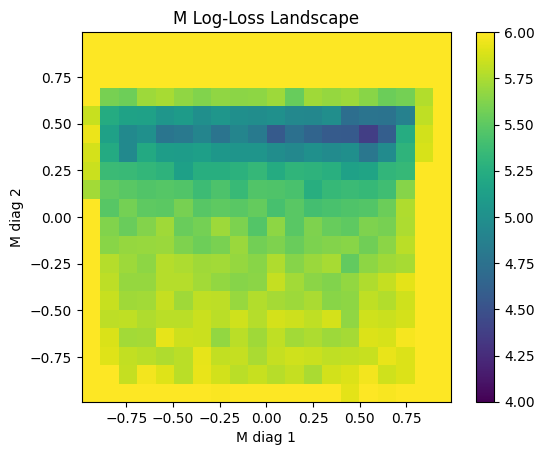

In [101]:
print(A)
print(kf.M_infty)

# Loss landscape
norm = matplotlib.colors.Normalize(4, 6)
c = plt.imshow(np.log10(losses_M_diag.T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
plt.xlabel('M diag 1')
plt.ylabel('M diag 2')

# Where does the Kalman filter fall?
envals = (kf.M_infty[0,0], kf.M_infty[1,1])
plt.plot(envals[0], envals[1], color='black', marker='o')
plt.annotate('Kalman filter', (envals[0], envals[1]),
             xytext=(envals[0]-0.2, envals[1]+0.05), color='black')

# What about the RNNs?
#plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')

plt.title(f'M Log-Loss Landscape')
plt.xlim(-1*mk_range, mk_range)
plt.ylim(-1*mk_range, mk_range)
plt.colorbar(c)
plt.show()

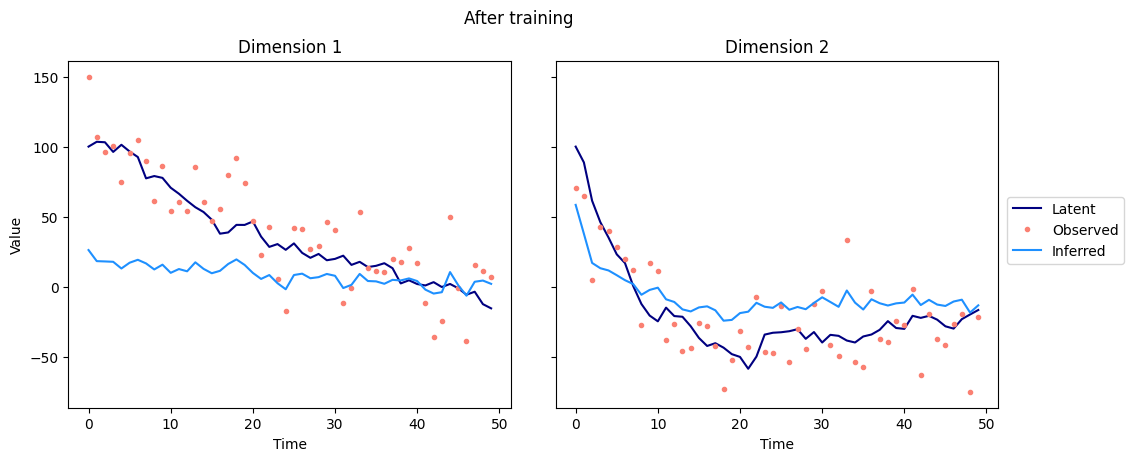

Loss 33300.114865698306
M = [[0.  0. ]
 [0.  0.5]]
K = [[ 0.18815947 -0.02897596]
 [-0.02897596  0.17988003]]


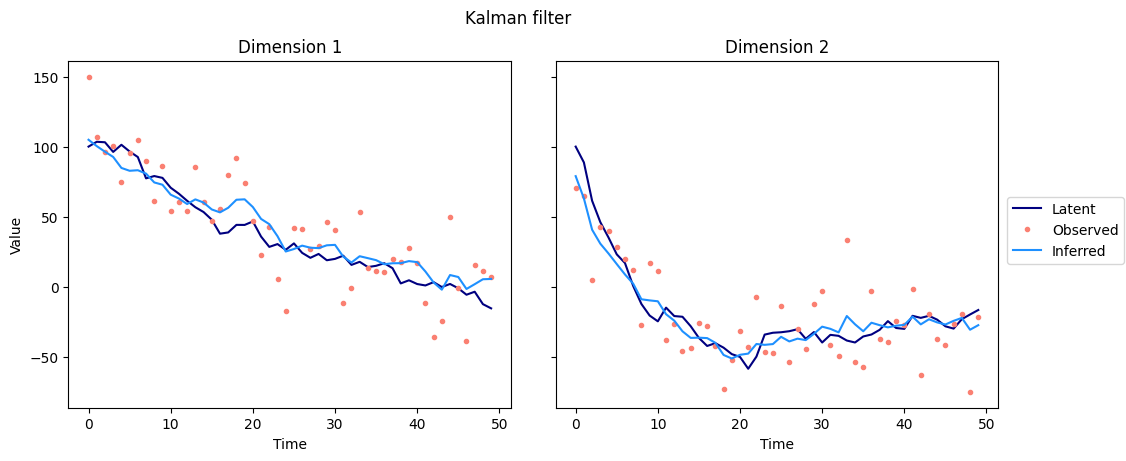

Loss 3274.8763558159394
M = [[ 0.76951788  0.01813344]
 [-0.04802477  0.75325781]]
K = [[ 0.18815947 -0.02897596]
 [-0.02897596  0.17988003]]
[[ 93.3297051  -17.43001498]
 [-17.430015    88.34934909]]


In [115]:
kf = SteadyStateKalmanFilter(proc)
ts, xs, ys = proc.simulate()

nn = NeuralNet(np.diag((0,0.5)), kf.K_infty, np.eye(2), proc.x0)
_, xhats = nn.forward(ys)
plot_hm_process('After training', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs, start_from))
print('M =', nn.M)
print('K =', nn.K)

xhats = kf.infer(ys)
plot_hm_process('Kalman filter', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs, start_from))
print('M =', kf.M_infty)
print('K =', kf.K_infty)

print(kf.Sigma_infty)

# Exploration 3
Now, what if we add some structure onto our connectivity matrix?

In [ ]:
# Let's see if the loss is impacted by random masks

def mk_rand_mask(num_neurons=3):
    return np.random.randint(0,2,size=(num_neurons,num_neurons))

def test_masks():
    for _ in range(2):
        mask = mk_rand_mask()
        print(mask)
        nn = NeuralNet(0.1*mk_rand_matrix(rng, 3), 0.1*mk_rand_matrix(rng, 3), np.eye(3), proc.x0, mask=mask)
        num_batches, losses = nn.train_until_converge(1e-6, 1000, 20, proc)
        plt.plot(losses)
        plt.xlabel('Batch')
        plt.ylabel('Mean loss')
        plt.show()

test_masks()